In [1]:
import torch
import numpy as np

from utils.data import get_synthetic_data
from utils.model import fit_eenn, fit_blr
from utils.blr import eenn_bayes_intervals
from utils.plotting import plot_segments, fill_between_segments
from utils.cqr import cqr
from avcs.regression import parallel_eenn_avcs_regression, eenn_avcs_regression, running_intersection, consistency, marginal_coverage

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter
from matplotlib import gridspec
import utils.plotting_style

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
SEED = 42

# Data params
DATASETS = ['wiggle', '3_clusters_homoskedastic']

# Model params
WIDTH = 20
DEPTH = 15

# AVCS params
ALPHA = 0.05
S = 10

# 1) Load data and fit the model
- fit an Early-Exit NN (EENN)
- fit Bayesian Linear Regression (BLR) at each exit

In [3]:
plotting_data = {}
for dataset in DATASETS:
    data = get_synthetic_data(dataset, SEED)
    X_train, y_train, X_test, y_test, y_max, y_min, x_min, x_max = data
    EENN = fit_eenn(width=WIDTH, depth=DEPTH, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, device=device)
    BLRs = fit_blr(width=WIDTH, depth=DEPTH, X_train=X_train, y_train=y_train, device=device, model=EENN)
    plotting_data[dataset] = (X_train, y_train, X_test, y_test, y_max, y_min, x_min, x_max, BLRs)

Nr. params: 7276
Epoch 0 | Loss: 6.9971
Epoch 100 | Loss: 0.2673
Epoch 200 | Loss: 0.2368
Epoch 300 | Loss: 0.2093
Epoch 400 | Loss: 0.2128
Nr. params: 7276
Epoch 0 | Loss: 5.6855
Epoch 100 | Loss: 0.0927
Epoch 200 | Loss: 0.0699
Epoch 300 | Loss: 0.0633
Epoch 400 | Loss: 0.0601


In [4]:
QR_MODELS = {}
for dataset in DATASETS:
    data = get_synthetic_data(dataset, SEED)
    X_train, y_train, X_test, y_test, y_max, y_min, x_min, x_max = data
    QR_MODELS[dataset] = fit_eenn(width=WIDTH, depth=DEPTH, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, device=device, loss='cqr', epochs=1000)

Nr. params: 7612
Epoch 0 | Loss: 1.6013
Epoch 100 | Loss: 0.5334
Epoch 200 | Loss: 0.2550
Epoch 300 | Loss: 0.1697
Epoch 400 | Loss: 0.1457
Epoch 500 | Loss: 0.1353
Epoch 600 | Loss: 0.1307
Epoch 700 | Loss: 0.1280
Epoch 800 | Loss: 0.1262
Epoch 900 | Loss: 0.1249
Nr. params: 7612
Epoch 0 | Loss: 1.5920
Epoch 100 | Loss: 0.8106
Epoch 200 | Loss: 0.5658
Epoch 300 | Loss: 0.3740
Epoch 400 | Loss: 0.2326
Epoch 500 | Loss: 0.1595
Epoch 600 | Loss: 0.1304
Epoch 700 | Loss: 0.1181
Epoch 800 | Loss: 0.1116
Epoch 900 | Loss: 0.1079


# 2) Compute EENN-AVCS and EENN-Bayes and EENN-CQR

In [5]:
C_AVCS = {}
C_BAYES = {}
C_QR = {}
C_CQR = {}
X_RANGE = {}

for dataset in DATASETS:
    X_train, y_train, X_test, y_test, y_max, y_min, x_min, x_max, BLRs = plotting_data[dataset]
    C_AVCS[dataset] = {}
    C_BAYES[dataset] = {}
    C_QR[dataset] = {}

    for test_set_type in ['X_test', 'X_range']:

        if test_set_type == 'X_test':
            x_star = torch.tensor(X_test).to(device)
        elif test_set_type == 'X_range':
            EPS = 0.5 if dataset == 'wiggle' else 0.3
            x_star = torch.tensor(np.linspace(x_min - EPS, x_max + EPS, 1000, dtype=np.float32)).to(device).reshape(-1, 1)
            X_RANGE[dataset] = x_star

        c_avcs, epistem_uncer, preds = parallel_eenn_avcs_regression(x_star=x_star, BLR_models=BLRs, alpha=ALPHA, S=S)
        c_avcs = [running_intersection(C) for C in c_avcs]
        c_bayes = eenn_bayes_intervals(x_star=x_star, BLR_models=BLRs)

        C_AVCS[dataset][test_set_type] = c_avcs, epistem_uncer, preds
        C_BAYES[dataset][test_set_type] = c_bayes

        c_qr = QR_MODELS[dataset](x_star)
        C_QR[dataset][test_set_type] = [list(map(tuple, c_qr[:, i, :].cpu().detach().numpy())) for i in range(c_qr.shape[1])]

/Users/metodjazbec/Desktop/phd/avcs_eens/EENN-AVCS/utils/blr.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, X_test = self.forward_with_features(torch.tensor(X_test))


In [6]:
# conformalized quantile regression
TEST_SET_TYPE = 'X_test'
C_CQR = {}
for dataset in DATASETS:
    C_CQR[dataset] = {}
    q_hats = cqr(QR_MODELS[dataset], dataset, SEED, device, alpha=ALPHA)

    c_cqr = []
    for i in range(len(C_QR[dataset][TEST_SET_TYPE])):
        c_cqr.append([(C_QR[dataset][TEST_SET_TYPE][i][j][0] - q_hats[j], C_QR[dataset][TEST_SET_TYPE][i][j][1] + q_hats[j]) for j in range(len(C_QR[dataset][TEST_SET_TYPE][i]))])
    C_CQR[dataset][TEST_SET_TYPE] = c_cqr

# 3) Plots

/Users/metodjazbec/opt/miniconda3/envs/eenn-avcs/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


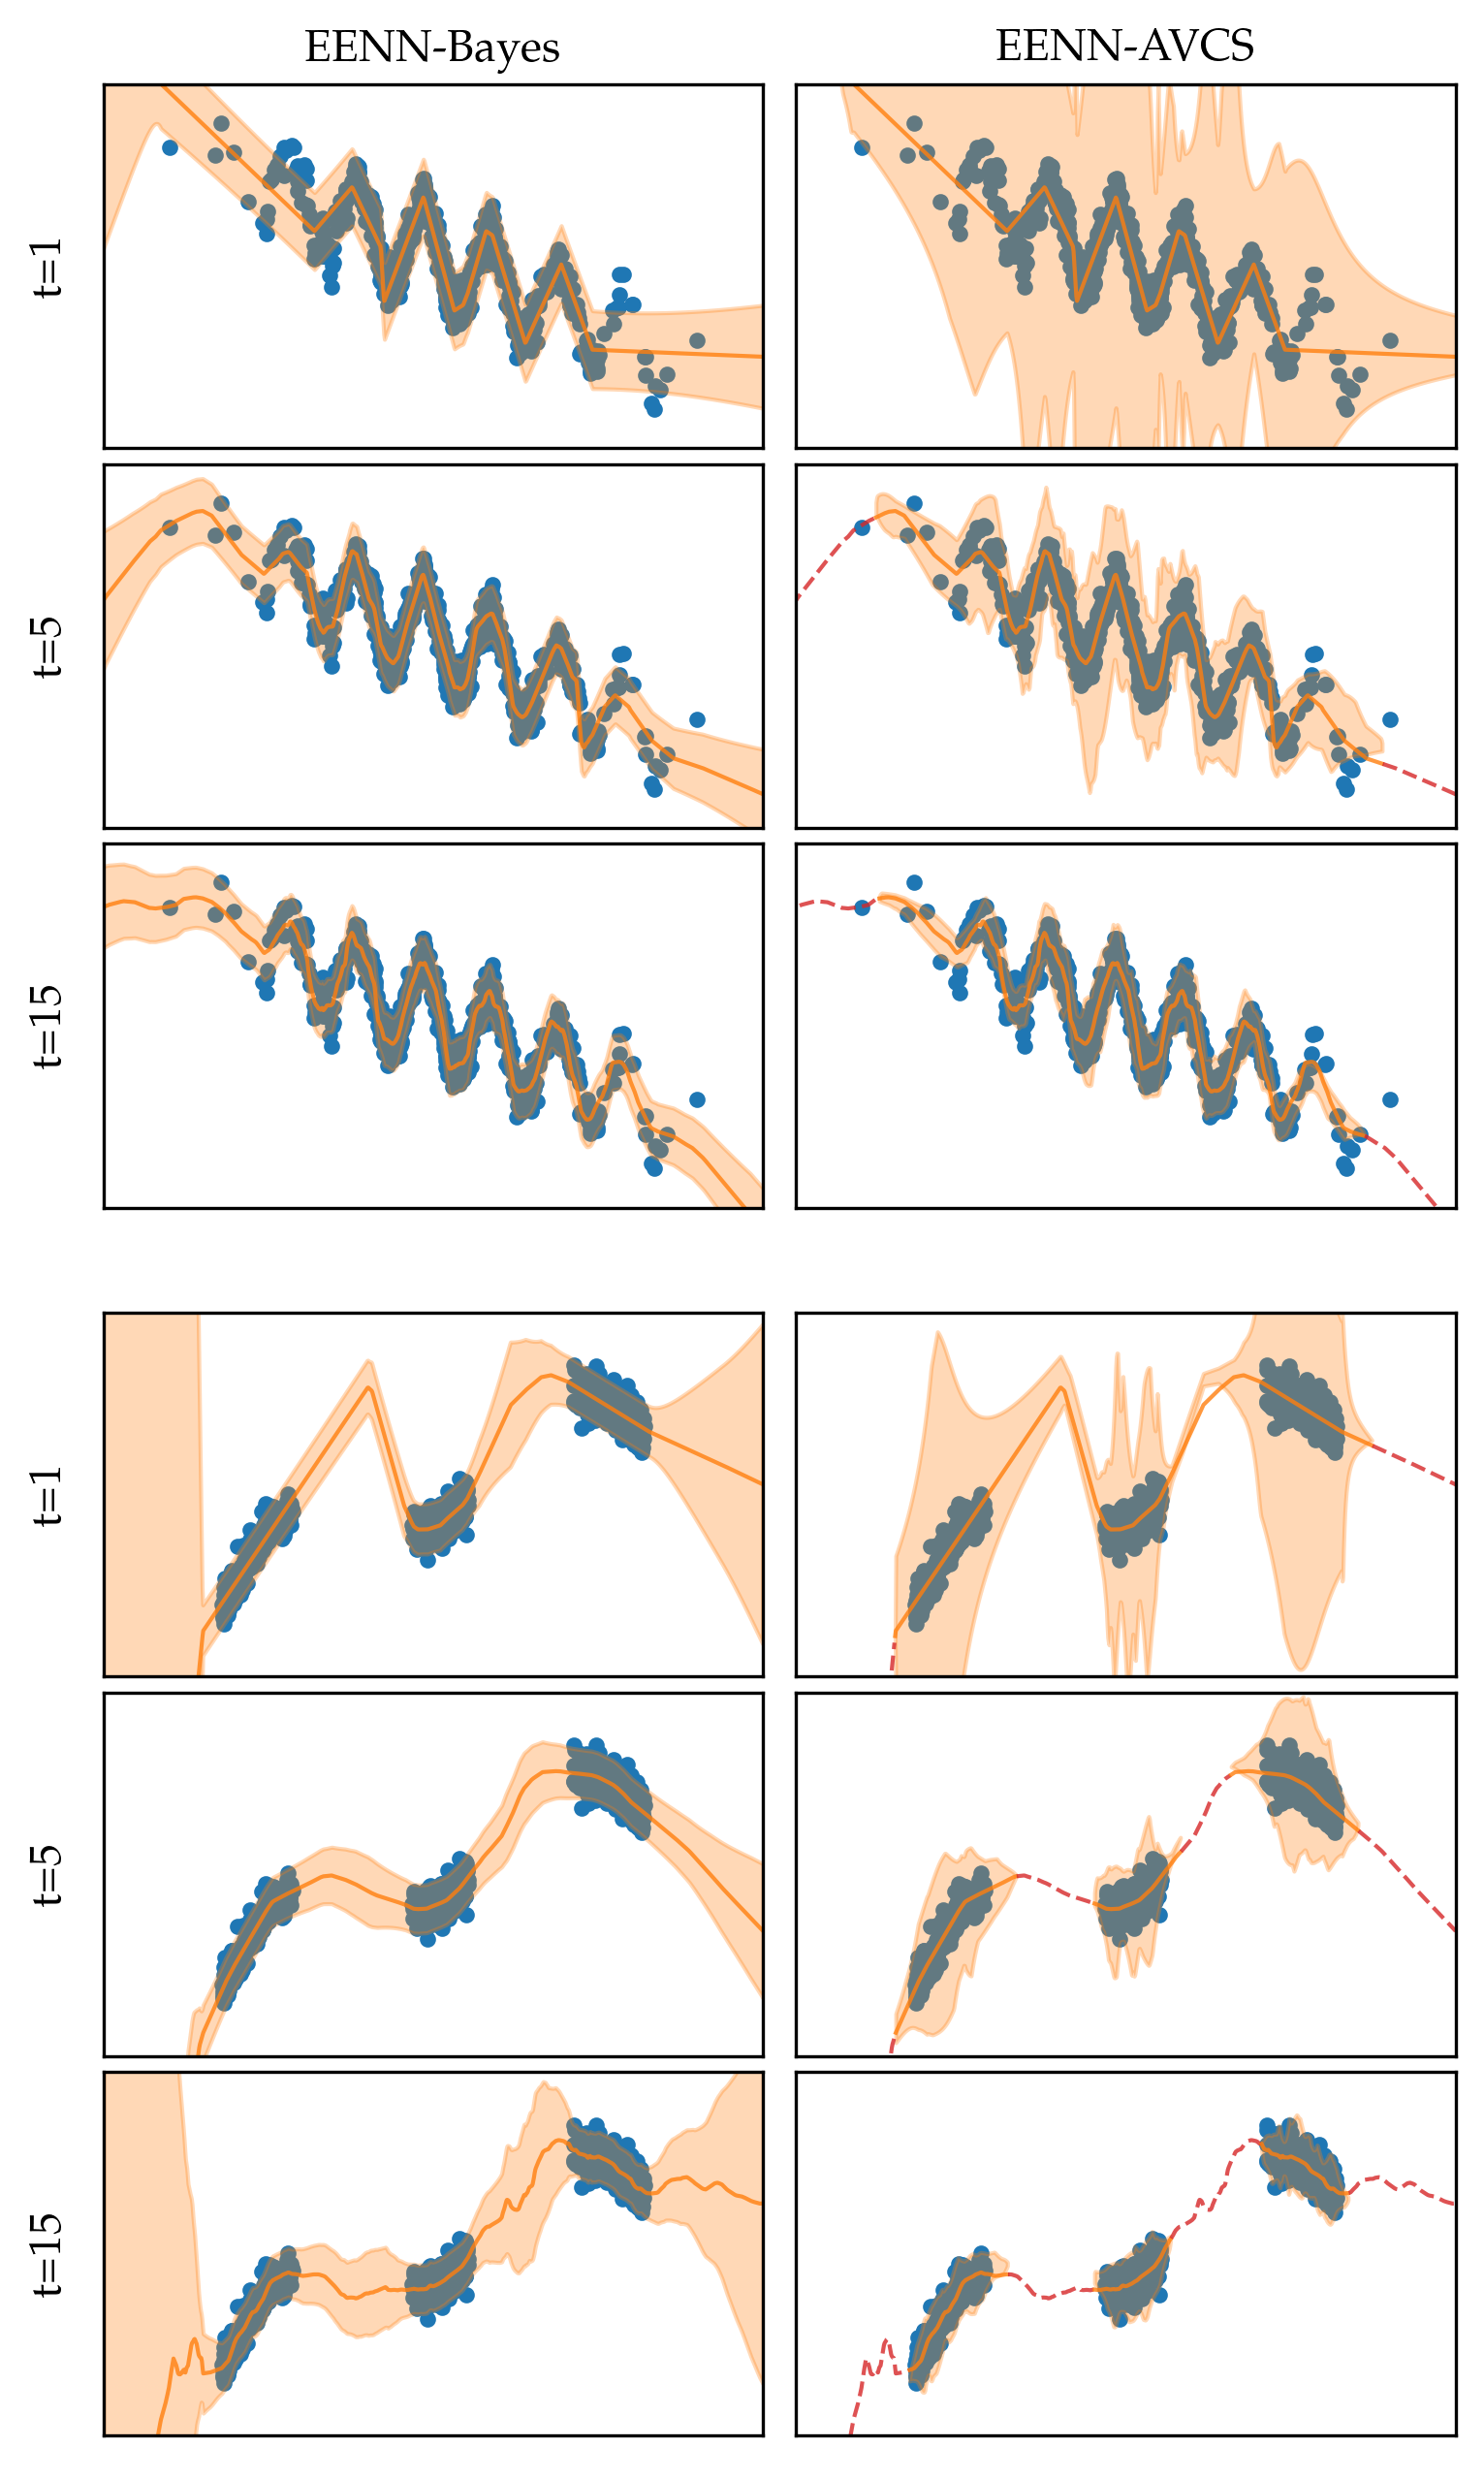

In [5]:
EPS_MAX = 0.02
t_ids = [1, 5, 15]
N_plot = len(t_ids)
TEST_SET_TYPE = 'X_range'

# Create a GridSpec object
gs = gridspec.GridSpec(len(t_ids)*2 + 1, 2, height_ratios=[1]*N_plot + [0.2] + [1]*N_plot)


fig, ax = plt.subplots(len(t_ids) * 2 + 1, 2, figsize=(6, len(t_ids) * 1.5 * 2 + 1.5), 
                       gridspec_kw={'hspace': 0.05, 'wspace': 0.05, 'height_ratios': gs.get_height_ratios()})

ax[0][1].set_title('EENN-AVCS')
ax[0][0].set_title('EENN-Bayes')

for dataset in DATASETS:
    X_train, y_train, X_test, y_test, y_max, y_min, x_min, x_max, BLRs = plotting_data[dataset]

    c_avcs = C_AVCS[dataset][TEST_SET_TYPE]
    c_avcs, epistem_uncer, preds = c_avcs
    c_bayes = C_BAYES[dataset][TEST_SET_TYPE]

    x_range = X_RANGE[dataset].detach().cpu().numpy().squeeze()

    offset = 0 if dataset == 'wiggle' else len(t_ids) + 1

    for i, d in enumerate(t_ids):
        ax[i + offset][0].set_ylabel(f't={d}')
        for j, intervals in enumerate([c_bayes, c_avcs]):
            
            upper_bound = np.array([C_x[d][1] for C_x in intervals])
            lower_bound = np.array([C_x[d][0] for C_x in intervals])

            ax[i + offset][j].scatter(X_train, y_train)

            ood_mask = (upper_bound == 0.) & (lower_bound == 0.)
            fill_between_segments(ax[i + offset][j], x_range, lower_bound, upper_bound, ood_mask, alpha=0.3, color='tab:orange')
            ood_mask = (upper_bound == 0.) & (lower_bound == 0.)
            plot_segments(ax[i + offset][j], x_range, preds[d], ood_mask, 'tab:red', 'tab:orange', '--', '-', alpha=0.8)

            ax[i + offset][j].set_xlim([x_min - EPS, x_max + EPS])
            ax[i + offset][j].set_ylim([y_min - EPS, y_max + EPS]) 
            ax[i + offset][j].set_xticks([])
            ax[i + offset][j].set_yticks([])

ax[len(t_ids)][0].axis('off')
ax[len(t_ids)][1].axis('off')

plt.show()

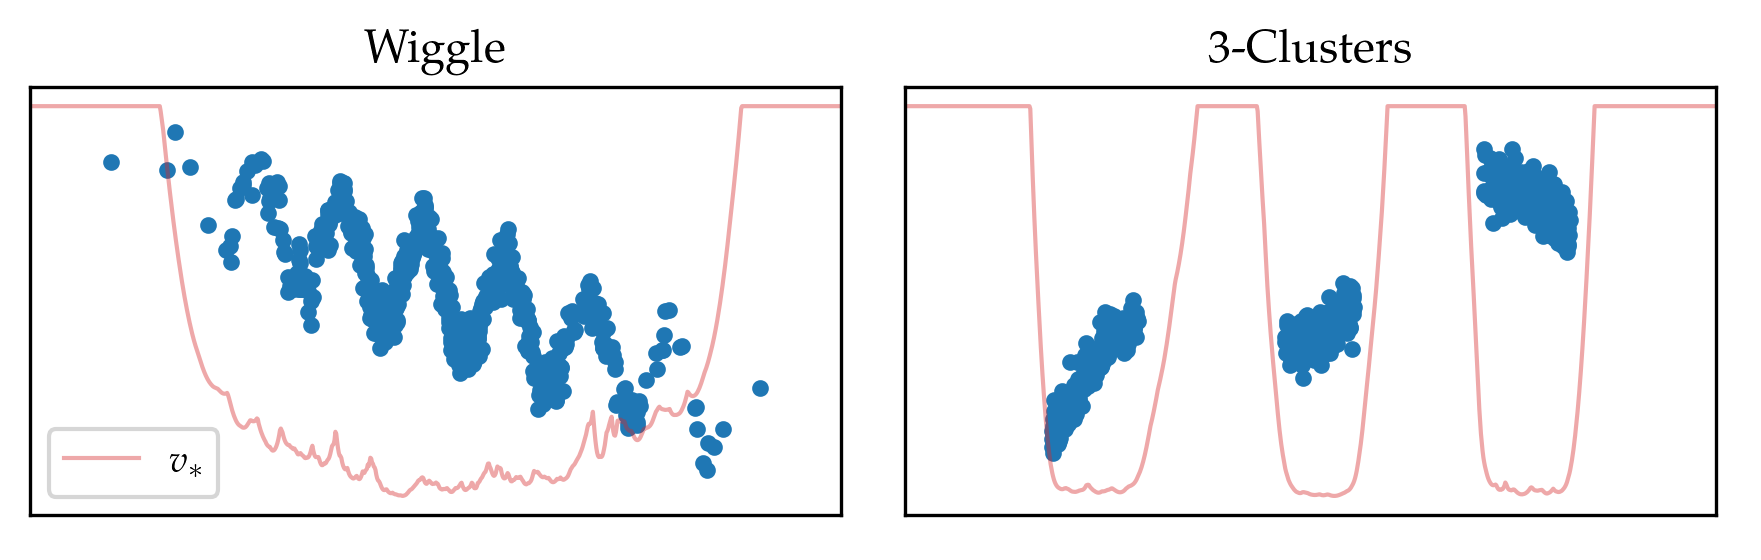

In [6]:
TEST_SET_TYPE = 'X_range'

fig, ax = plt.subplots(1, 2, figsize=(6, 1 * 2))

ax[0].set_title('Wiggle')
ax[1].set_title('3-Clusters')

for i, dataset in enumerate(DATASETS):
    X_train, y_train, X_test, y_test, y_max, y_min, x_min, x_max, BLRs = plotting_data[dataset]

    c_avcs = C_AVCS[dataset][TEST_SET_TYPE]
    c_avcs, epistem_uncer, preds = c_avcs
    c_bayes = C_BAYES[dataset][TEST_SET_TYPE]

    x_range = X_RANGE[dataset].detach().cpu().numpy().squeeze()

    ax[i].scatter(X_train, y_train)

    ax2 = ax[i].twinx()
    ax2.plot(x_range, np.clip(np.stack(epistem_uncer).squeeze().mean(axis=0), 0., EPS_MAX), 
             color='tab:red', alpha=0.4, label='$v_*$')

    ax2.set_yticks([])

    if i == 0:
        ax2.legend(loc='lower left')

    ax[i].set_xlim([x_min - EPS, x_max + EPS])
    ax[i].set_ylim([y_min - EPS, y_max + EPS])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

ax[0].axis('off')
ax[1].axis('off')

plt.show()

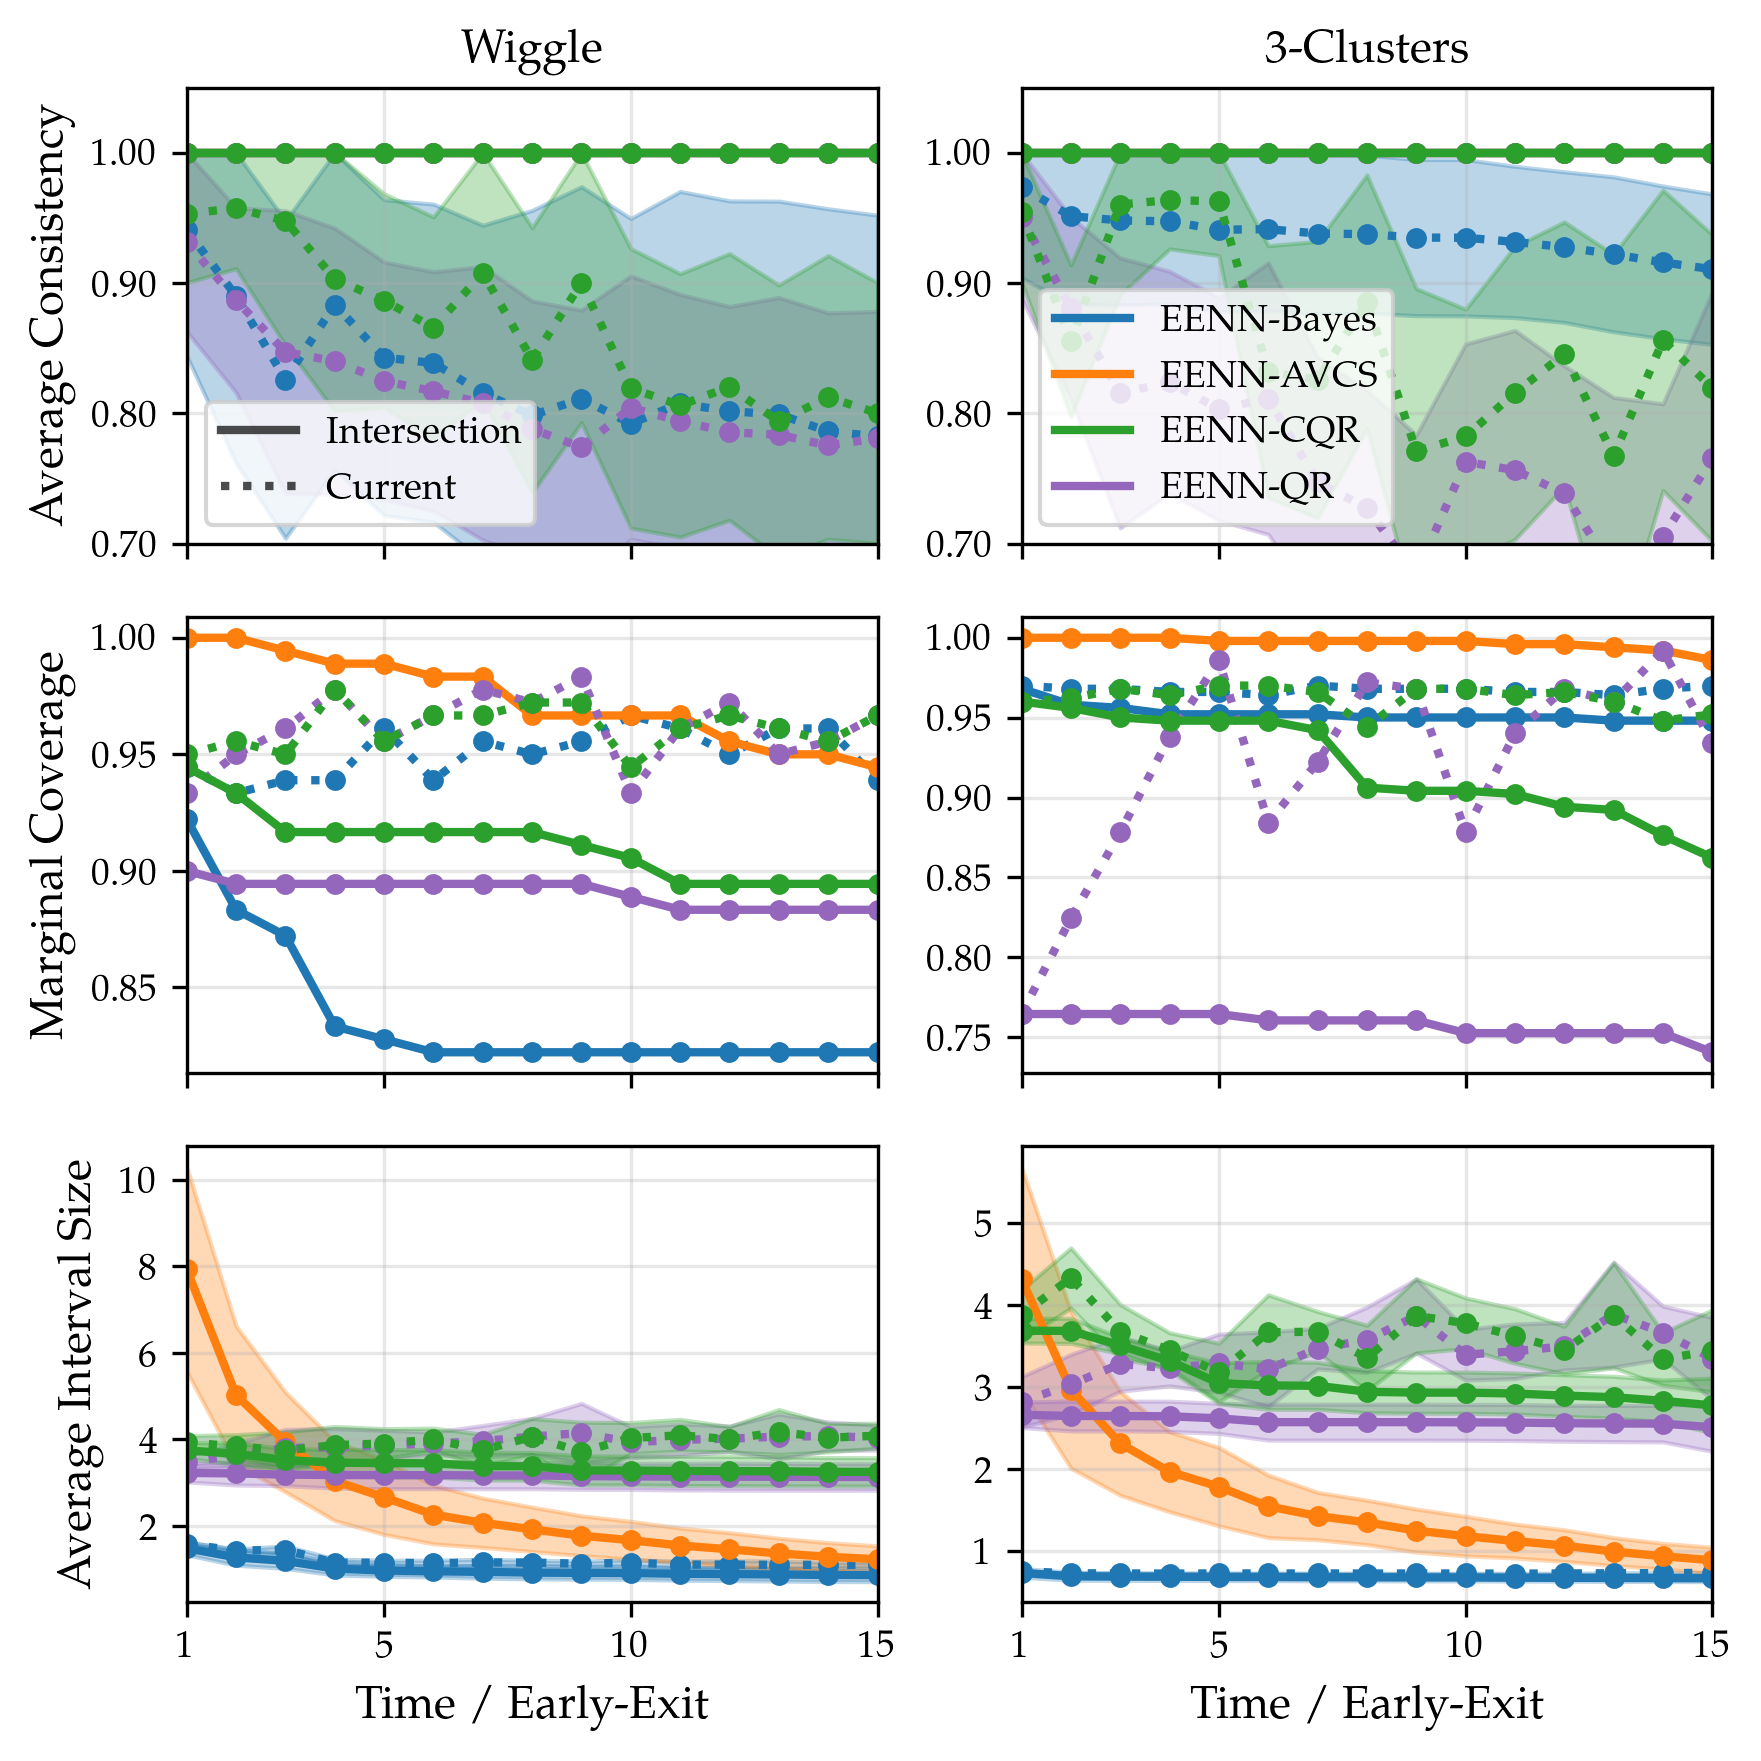

In [7]:
TEST_SET_TYPE = 'X_test'
COLOR_DICT = {'EENN-Bayes': 'tab:blue', 'EENN-AVCS': 'tab:orange', 'EENN-QR': 'tab:purple', 'EENN-CQR': 'tab:green'}

fig, ax = plt.subplots(3, 2, figsize=(6, 6), sharex=True)

for i, dataset in enumerate(DATASETS):
    X_train, y_train, X_test, y_test, _, _, _, _,  BLRs = plotting_data[dataset]
    t_arr = [t for t in range(1, len(BLRs))]

    c_avcs = C_AVCS[dataset][TEST_SET_TYPE]
    c_avcs, epistem_uncer, preds = c_avcs
    c_bayes = C_BAYES[dataset][TEST_SET_TYPE]
    c_bayes_intersect = [running_intersection(C) for C in c_bayes]
    c_qr = C_QR[dataset][TEST_SET_TYPE]
    c_qr_intersect = [running_intersection(C) for C in c_qr]
    c_cqr = C_CQR[dataset][TEST_SET_TYPE]
    c_cqr_intersect = [running_intersection(C) for C in c_cqr]

    for label, intervals in zip([('EENN-Bayes', 'current'), ('EENN-Bayes', 'intersection'), 
                                 ('EENN-AVCS', 'intersection'), 
                                 ('EENN-QR', 'intersection'), ('EENN-QR', 'current'), 
                                 ('EENN-CQR', 'intersection'), ('EENN-CQR', 'current')],
                                [c_bayes, c_bayes_intersect, 
                                 c_avcs, 
                                 c_qr_intersect, c_qr, 
                                 c_cqr_intersect, c_cqr]):
        
        label, interval_type = label
        color = COLOR_DICT[label]
        line_style = 'solid' if interval_type == 'intersection' else 'dotted'
        
        # plot consistency with std in the first row
        consistency_arr = consistency(intervals)
        consistency_mean = np.mean(consistency_arr, axis=0)
        consistency_std = np.std(consistency_arr, axis=0)
        ax[0, i].plot(t_arr, consistency_mean, label=label, marker='o', color=color, linestyle=line_style, ms=4, lw=2)
        upper_std = [min(x, 1.) for x in consistency_mean + consistency_std]
        ax[0, i].fill_between(t_arr, consistency_mean - consistency_std, upper_std, alpha=0.3, color=color)
        ax[0, i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax[0, i].set_ylim([0.7, 1.05])

        # plot marginal coverage in the second row
        ax[1, i].plot(t_arr, marginal_coverage(y_test, intervals)[1:], label=label, marker='o', color=color, linestyle=line_style, ms=4, lw=2)
        ax[1, i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
        # plot average interval size with std in the third row
        interval_size_mean = np.mean([np.array([C_x[d][1] - C_x[d][0] for C_x in intervals]) for d in range(DEPTH + 1)], axis=1)[1:]
        interval_size_std = np.std([np.array([C_x[d][1] - C_x[d][0] for C_x in intervals]) for d in range(DEPTH + 1)], axis=1)[1:]
        ax[2, i].plot(t_arr, interval_size_mean, label='BNN (current)', marker='o', color=color, linestyle=line_style, ms=4, lw=2)
        ax[2, i].fill_between(t_arr, interval_size_mean - interval_size_std, interval_size_mean + interval_size_std, alpha=0.3, color=color)
        ax[2, i].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
      

ax[0, 0].set_title('Wiggle')
ax[0, 1].set_title('3-Clusters')
ax[0, 0].set_ylabel('Average Consistency')
ax[2, 0].set_ylabel('Average Interval Size')
ax[1, 0].set_ylabel('Marginal Coverage')
ax[2, 0].set_xlabel('Time / Early-Exit')
ax[2, 1].set_xlabel('Time / Early-Exit')
ax[0, 0].set_xlim([1 , DEPTH])
ax[0, 0].set_xticks([1, 5, 10, 15])


lines1 = [
    Line2D([0], [0], color='black', lw=2, linestyle='-', alpha=0.7),
    Line2D([0], [0], color='black', lw=2, linestyle='dotted', alpha=0.7),
]
labels1 = [
    "Intersection",
    "Current"
]

lines2 = [
    Line2D([0], [0], color='tab:blue', lw=2, linestyle='-'),
    Line2D([0], [0], color='tab:orange', lw=2, linestyle='-'),
    Line2D([0], [0], color='tab:green', lw=2, linestyle='-'),
    Line2D([0], [0], color='tab:purple', lw=2, linestyle='-'),

]
labels2 = [
    "EENN-Bayes",
    "EENN-AVCS",
    "EENN-CQR",
    "EENN-QR"
]

legend1 = ax[0, 0].legend(lines1, labels1, loc='lower left')
legend2 = ax[0, 1].legend(lines2, labels2, loc='lower left')

plt.show()

In [8]:
TEST_SET_TYPE = 'X_test'
DATASET = '3_clusters_homoskedastic'
# DATASET = 'wiggle'

X_train, y_train, X_test, y_test, y_max, y_min, x_min, x_max, BLRs = plotting_data[DATASET]
x_star = torch.tensor(X_test).to(device)


C_AVCS_PAR, C_AVCS_MUL = {}, {}
S_ARR = [1, 2, 5, 10]
for S in S_ARR:
    c_avcs, _, _ = parallel_eenn_avcs_regression(x_star=x_star, BLR_models=BLRs, alpha=ALPHA, S=S)
    c_avcs = [running_intersection(C) for C in c_avcs]
    C_AVCS_PAR[S] = c_avcs

    c_avcs_mul, _, _ = eenn_avcs_regression(x_star=x_star, BLR_models=BLRs, alpha=ALPHA, S=S)
    c_avcs_mul = [running_intersection(C) for C in c_avcs_mul]
    C_AVCS_MUL[S] = c_avcs_mul

c_bayes = C_BAYES[DATASET][TEST_SET_TYPE]
c_bayes_intersect = [running_intersection(C) for C in c_bayes]

In [9]:
COLOR_DICT = {0: 'tab:blue', 1: 'tab:red', 2: 'tab:green', 3: 'tab:orange', 4: 'tab:purple', 5: 'tab:brown'}

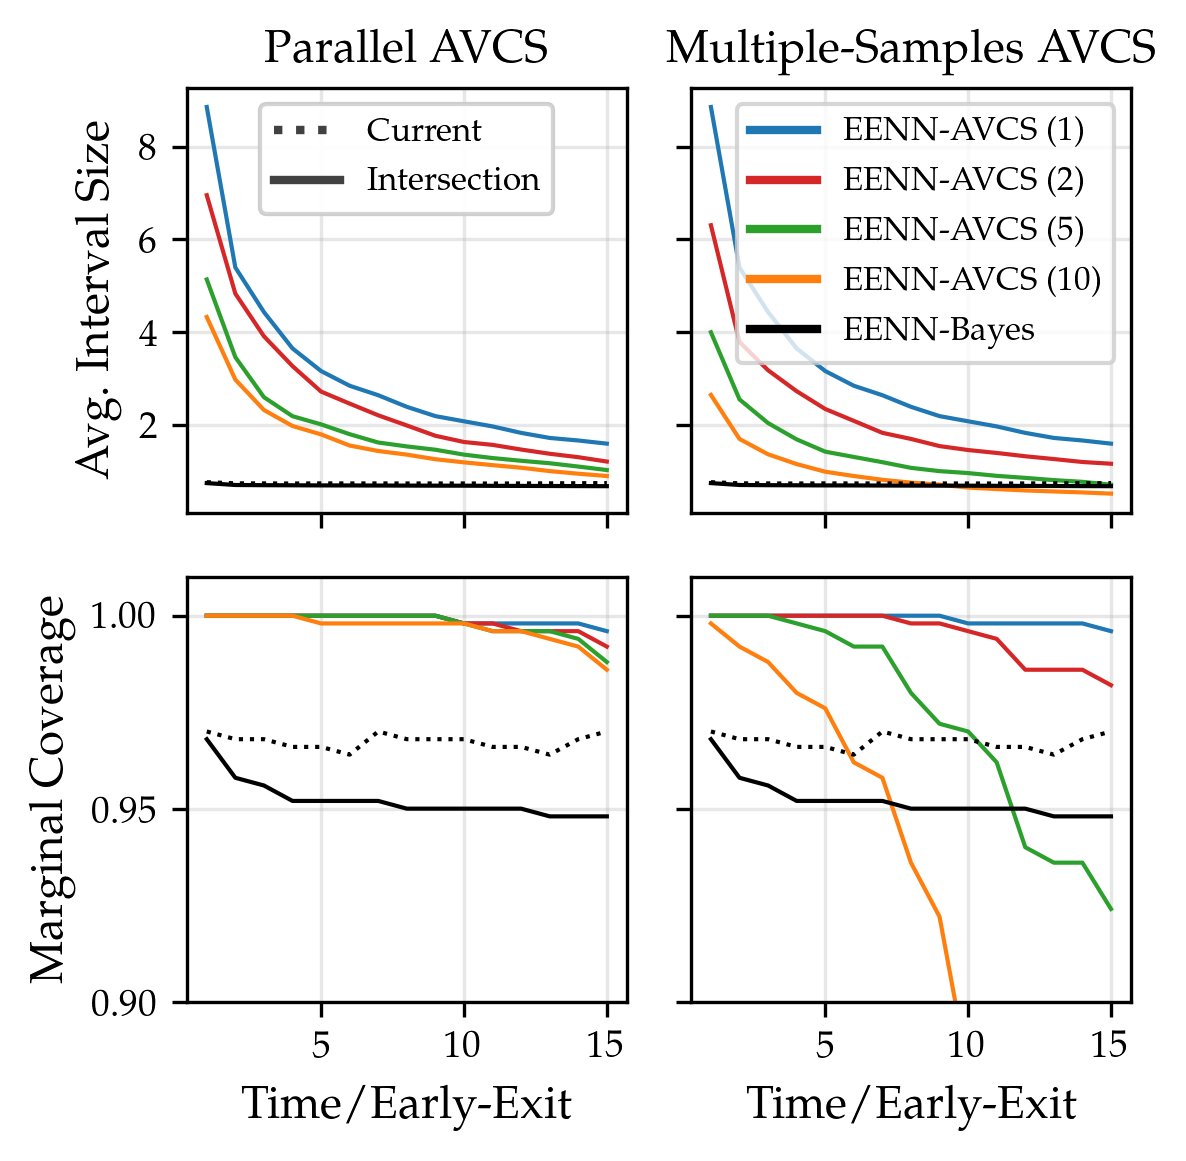

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(4, 4), sharex=True, sharey='row')
t_arr = [x for x in range(1, DEPTH + 1)]

for j, C_AVCS in enumerate([C_AVCS_PAR, C_AVCS_MUL]):
    for i, S in enumerate(S_ARR):
        ax[0, j].plot(t_arr, np.mean([np.array([C_x[d][1] - C_x[d][0] for C_x in C_AVCS[S]]) for d in range(1, DEPTH + 1)], axis=1), 
                      label=f'AVCS ({S})', color=COLOR_DICT[i], linestyle='-')
        ax[1, j].plot(t_arr, marginal_coverage(y_test, C_AVCS[S])[1:], label=f'AVCS ({S})', color=COLOR_DICT[i], linestyle='-')
    
    ax[0, j].plot(t_arr, np.mean([np.array([C_x[d][1] - C_x[d][0] for C_x in c_bayes]) for d in range(1, DEPTH + 1)], axis=1),
                    label=f'BAYES current', color='black', linestyle='dotted')
    ax[0, j].plot(t_arr, np.mean([np.array([C_x[d][1] - C_x[d][0] for C_x in c_bayes_intersect]) for d in range(1, DEPTH + 1)], axis=1),
                    label=f'BAYES intersection', color='black', linestyle='-')
    ax[1, j].plot(t_arr, marginal_coverage(y_test, c_bayes)[1:], label=f'BAYES current', color='black', linestyle='dotted')
    ax[1, j].plot(t_arr, marginal_coverage(y_test, c_bayes_intersect)[1:], label=f'BAYES intersection', color='black', linestyle='-')

    ax[1, j].set_xlabel('Time/Early-Exit')

ax[0, 0].set_ylabel('Avg. Interval Size')
ax[1, 0].set_ylabel('Marginal Coverage')
ax[0, 0].set_title('Parallel AVCS')
ax[0, 1].set_title('Multiple-Samples AVCS')

# ax[1, 0].set_ylim([0.8, 1.01])
# ax[1, 0].set_yticks([0.8, 0.85, 0.9, 0.95, 1.])
ax[1, 0].set_ylim([0.9, 1.01])
ax[1, 0].set_yticks([0.9, 0.95, 1.])

lines1 = [
    Line2D([0], [0], color='black', lw=2, linestyle='dotted', alpha=0.7),
    Line2D([0], [0], color='black', lw=2, linestyle='-', alpha=0.7),
]
labels1 = [
    "Current",
    "Intersection"
]

lines2 = [Line2D([0], [0], color=color, lw=2, linestyle='-') for color in COLOR_DICT.values()][:len(S_ARR)] + [Line2D([0], [0], color='black', lw=2, linestyle='-')]
labels2 = [f"EENN-AVCS ({S})" for S in S_ARR] + ["EENN-Bayes"]

legend1 = ax[0, 0].legend(lines1, labels1, loc='upper center', fontsize=8)
ax[0, 0].add_artist(legend1)
legend2 = ax[0, 1].legend(lines2, labels2, loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()
